# Boosting

In [1]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.datasets import make_blobs, make_circles, make_classification, fetch_olivetti_faces
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import confusion_matrix, accuracy_score, precision_recall_curve, roc_curve, auc
from statistics import mode
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBClassifier
import time
from collections import Counter

%matplotlib inline

/Users/sharad/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

In [2]:
shop = pd.read_csv('/Users/sharad/Courses/DATA_5600/Data/online_shoppers_intention.csv')
print(shop.shape)
shop.head()

(12330, 18)


,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,OperatingSystems,Browser,Region,TrafficType,VisitorType,Weekend,Revenue
0,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,1,1,1,1,Returning_Visitor,False,False
1,0,0.0,0,0.0,2,64.000000,0.00,0.10,0.0,0.0,Feb,2,2,1,2,Returning_Visitor,False,False
2,0,0.0,0,0.0,1,0.000000,0.20,0.20,0.0,0.0,Feb,4,1,9,3,Returning_Visitor,False,False
3,0,0.0,0,0.0,2,2.666667,0.05,0.14,0.0,0.0,Feb,3,2,2,4,Returning_Visitor,False,False
4,0,0.0,0,0.0,10,627.500000,0.02,0.05,0.0,0.0,Feb,3,3,1,4,Returning_Visitor,True,False


In [3]:
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  int64  
 12  Browser                  12330 non-null  int64  
 13  Region                   12330 non-null  int64  
 14  TrafficType           

In [4]:
shop.OperatingSystems = shop.OperatingSystems.astype(str)
shop.Browser = shop.Browser.astype(str)
shop.Region = shop.Region.astype(str)
shop.TrafficType = shop.TrafficType.astype(str)
shop.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12330 entries, 0 to 12329
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Administrative           12330 non-null  int64  
 1   Administrative_Duration  12330 non-null  float64
 2   Informational            12330 non-null  int64  
 3   Informational_Duration   12330 non-null  float64
 4   ProductRelated           12330 non-null  int64  
 5   ProductRelated_Duration  12330 non-null  float64
 6   BounceRates              12330 non-null  float64
 7   ExitRates                12330 non-null  float64
 8   PageValues               12330 non-null  float64
 9   SpecialDay               12330 non-null  float64
 10  Month                    12330 non-null  object 
 11  OperatingSystems         12330 non-null  object 
 12  Browser                  12330 non-null  object 
 13  Region                   12330 non-null  object 
 14  TrafficType           

In [5]:
shop.Revenue = np.where(shop.Revenue == True,1,0)
shop.Weekend = np.where(shop.Weekend == True,1,0)
shop = pd.get_dummies(shop, drop_first=True)

X = shop.drop(columns=['Revenue'])
y = shop['Revenue']

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=24)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=24)
print(X_train.shape, X_test.shape, X_val.shape)

(7398, 68) (2466, 68) (2466, 68)


## Random Forests Baseline

In [10]:
Counter(y)

Counter({0: 10422, 1: 1908})

In [11]:
10422/(10422+1908)

0.8452554744525548

In [12]:
t0 = time.time()
forest = RandomForestClassifier(n_estimators=100,
                            max_depth=None,
                            oob_score=False,
                            random_state=21)
forest.fit(X_train,y_train)
t1 = time.time()
val_acc = forest.score(X_val, y_val)
print(f'Time to fit: {t1-t0}. Validation accuracy: {val_acc}')

Time to fit: 0.5997090339660645. Validation accuracy: 0.8994322789943228


In [13]:
forest.score(X_test, y_test)

0.9067315490673155

## AdaBoost
https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html#sklearn.ensemble.AdaBoostClassifier

In [14]:
t0 = time.time()
ada = AdaBoostClassifier(n_estimators=100).fit(X_train,y_train)
val_acc = ada.score(X_val,y_val)
t1 = time.time()
print(f'Time to fit: {t1-t0}. Validation accuracy: {val_acc}')

Time to fit: 0.6449482440948486. Validation accuracy: 0.8888888888888888


### Hyperparameter tuning
* `n_estimators`: Number of trees (default=50)
* `learning_rate`: Weight applied to each classifier at each boosting iteration. Higher learning rate increases the contribution of each classifier (default=1.0)
* `base_estimator`: The base classifier used for boosting. The default is a `DecisionTreeClassifier` with `max_dept=1`

Completed 1 trees
Completed 11 trees
Completed 21 trees
Completed 31 trees
Completed 41 trees
Completed 51 trees
Completed 61 trees
Completed 71 trees
Completed 81 trees
Completed 91 trees
Completed 101 trees
Completed 111 trees
Completed 121 trees
Completed 131 trees
Completed 141 trees
Completed 151 trees
Completed 161 trees
Completed 171 trees
Completed 181 trees
Completed 191 trees
Completed 201 trees
Completed 211 trees
Completed 221 trees
Completed 231 trees
Completed 241 trees


Text(0, 0.5, 'Validation Set Accuracy')

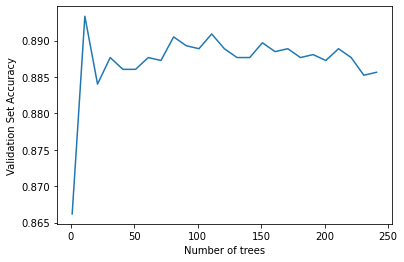

In [16]:
num_trees = np.arange(1, 251, 10)
val_acc_list = []

for n in num_trees:
    ada = AdaBoostClassifier(n_estimators=n).fit(X_train,y_train)
    val_acc_list.append(ada.score(X_val,y_val))
    print(f'Completed {n} trees')

plt.plot(num_trees, val_acc_list)
plt.xlabel('Number of trees')
plt.ylabel('Validation Set Accuracy')

In [18]:
num_trees[np.argmax(val_acc_list)]

11

Completed learning rate of 1e-05
Completed learning rate of 0.10527263157894737
Completed learning rate of 0.21053526315789475
Completed learning rate of 0.3157978947368421
Completed learning rate of 0.4210605263157895
Completed learning rate of 0.5263231578947368
Completed learning rate of 0.6315857894736842
Completed learning rate of 0.7368484210526316
Completed learning rate of 0.8421110526315789
Completed learning rate of 0.9473736842105263
Completed learning rate of 1.0526363157894738
Completed learning rate of 1.1578989473684211
Completed learning rate of 1.2631615789473685
Completed learning rate of 1.3684242105263158
Completed learning rate of 1.4736868421052634
Completed learning rate of 1.5789494736842107
Completed learning rate of 1.684212105263158
Completed learning rate of 1.7894747368421053
Completed learning rate of 1.8947373684210527
Completed learning rate of 2.0


Text(0, 0.5, 'Validation Set Accuracy')

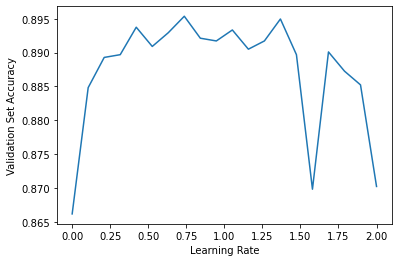

In [21]:
learning_rates = np.linspace(0.00001,2,20)
val_acc_list = []

for lr in learning_rates:
    ada = AdaBoostClassifier(n_estimators=11, learning_rate=lr).fit(X_train,y_train)
    val_acc_list.append(ada.score(X_val,y_val))
    print(f'Completed learning rate of {lr}')

plt.plot(learning_rates, val_acc_list)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Set Accuracy')

In [23]:
learning_rates[np.argmax(val_acc_list)]

0.7368484210526316

In [24]:
ada = AdaBoostClassifier(n_estimators=11, learning_rate=learning_rates[np.argmax(val_acc_list)]).fit(X_train,y_train)
ada.score(X_val,y_val)

0.8953771289537713

### Grid search for optimal set of hyperparameters

In [29]:
num_trees = np.arange(10, 100, 10)
learning_rates = np.linspace(0.1,1,10)
val_acc_list = []
hyperparameter_combo = []

for n in num_trees:
    for lr in learning_rates:
        ada = AdaBoostClassifier(n_estimators=n, learning_rate=lr).fit(X_train,y_train)
        val_acc_list.append(ada.score(X_val,y_val))
        print(f'Completed tree {n} and learning rate of {lr}')
        hyperparameter_combo.append((n,lr))

Completed tree 10 and learning rate of 0.1
Completed tree 10 and learning rate of 0.2
Completed tree 10 and learning rate of 0.30000000000000004
Completed tree 10 and learning rate of 0.4
Completed tree 10 and learning rate of 0.5
Completed tree 10 and learning rate of 0.6
Completed tree 10 and learning rate of 0.7000000000000001
Completed tree 10 and learning rate of 0.8
Completed tree 10 and learning rate of 0.9
Completed tree 10 and learning rate of 1.0
Completed tree 20 and learning rate of 0.1
Completed tree 20 and learning rate of 0.2
Completed tree 20 and learning rate of 0.30000000000000004
Completed tree 20 and learning rate of 0.4
Completed tree 20 and learning rate of 0.5
Completed tree 20 and learning rate of 0.6
Completed tree 20 and learning rate of 0.7000000000000001
Completed tree 20 and learning rate of 0.8
Completed tree 20 and learning rate of 0.9
Completed tree 20 and learning rate of 1.0
Completed tree 30 and learning rate of 0.1
Completed tree 30 and learning rate

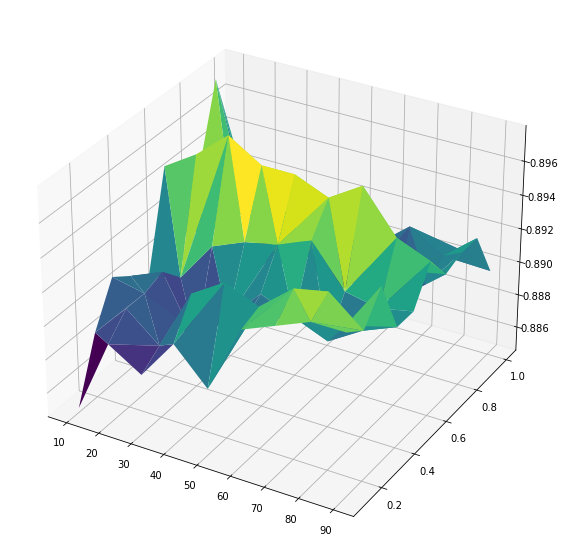

In [30]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[0],
             list(zip(*hyperparameter_combo))[1],
             val_acc_list,cmap='viridis')

In [31]:
print(np.max(val_acc_list), hyperparameter_combo[np.argmax(val_acc_list)])

0.8978102189781022 (10, 0.9)


In [32]:
ada = AdaBoostClassifier(n_estimators=hyperparameter_combo[np.argmax(val_acc_list)][0], 
                         learning_rate=hyperparameter_combo[np.argmax(val_acc_list)][1]).fit(X_train,y_train)
ada.score(X_test,y_test)

0.9014598540145985

## Gradient Boosting

In [33]:
t0 = time.time()
boost = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,
    max_depth=1, random_state=0).fit(X_train, y_train)
t1 = time.time()
val_acc = boost.score(X_val, y_val)
print(f'Time to fit: {t1-t0}. Validation accuracy: {val_acc}')

Time to fit: 0.4191470146179199. Validation accuracy: 0.8969991889699919


### Hyperparameters
* `loss`: The loss function to be optimized. `log_loss` is the default and `exponential` is equivalent to AdaBoost.
* `learning_rate`: default = 0.1
* `n_estimators`: number of trees
* `subsample`: The fraction of samples to be used for fitting the individual base learners. Choosing `subsample < 1.0` reduces the variances and increases bias.
* `min_samples_split`, `min_samples_leaf`, `min_weight_fraction_leaf`, `max_depth`, `min_impurity_decrease`, `max_leaf_nodes`: All of these arguments control the depth of the tree. In practice, we will likely just stick with `max_depth` but conceivably all of these should be considered.
* `max_features`: number of variables to be considered at each splt
* `ccp_alpha`: For cost-complexity pruning.

### Extra Arguments
* `warm_start`: When set to `True`, this will allow us to use an existing ensemble to continue adding to.
* `validation_fraction`: The proportion of training data to set aside as a validation set to determine early stopping criterion.

#### Exhaustive grid search
Approximately 21T years to exhaustively search all possible hyperparameter combinations if we try 20 unique values for each of the 11 hyperparameters

In [34]:
num_hyperparameters = 11
potential_values = 20
sec_per_combo = 1
years_to_completion = ((num_hyperparameters ** potential_values)*sec_per_combo)/60/60/24/365
years_to_completion

21332762396390.16

Completed 1 trees
Completed 2 trees
Completed 3 trees
Completed 4 trees
Completed 5 trees
Completed 6 trees
Completed 7 trees
Completed 8 trees
Completed 9 trees
Completed 10 trees


Text(0, 0.5, 'Validation Set Accuracy')

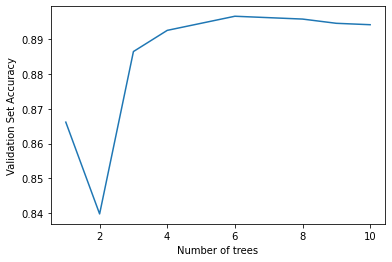

In [38]:
num_trees = np.arange(1, 11, 1)
val_acc_list = []

for n in num_trees:
    boost = GradientBoostingClassifier(n_estimators=n, learning_rate=1.0,
                                        max_depth=1, random_state=0).fit(X_train, y_train)
    
    val_acc_list.append(boost.score(X_val, y_val))
    print(f'Completed {n} trees')

plt.plot(num_trees, val_acc_list)
plt.xlabel('Number of trees')
plt.ylabel('Validation Set Accuracy')

Completed learning rate 1e-05
Completed learning rate 0.10527263157894737
Completed learning rate 0.21053526315789475
Completed learning rate 0.3157978947368421
Completed learning rate 0.4210605263157895
Completed learning rate 0.5263231578947368
Completed learning rate 0.6315857894736842
Completed learning rate 0.7368484210526316
Completed learning rate 0.8421110526315789
Completed learning rate 0.9473736842105263
Completed learning rate 1.0526363157894738
Completed learning rate 1.1578989473684211
Completed learning rate 1.2631615789473685
Completed learning rate 1.3684242105263158
Completed learning rate 1.4736868421052634
Completed learning rate 1.5789494736842107
Completed learning rate 1.684212105263158
Completed learning rate 1.7894747368421053
Completed learning rate 1.8947373684210527
Completed learning rate 2.0


Text(0, 0.5, 'Validation Set Accuracy')

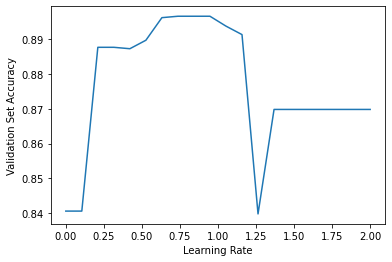

In [40]:
learning_rates = np.linspace(0.00001,2,20)
val_acc_list = []

for lr in learning_rates:
    boost = GradientBoostingClassifier(n_estimators=6, learning_rate=lr,
                                        max_depth=1, random_state=0).fit(X_train, y_train)
    
    val_acc_list.append(boost.score(X_val, y_val))
    print(f'Completed learning rate {lr}')

plt.plot(learning_rates, val_acc_list)
plt.xlabel('Learning Rate')
plt.ylabel('Validation Set Accuracy')

Completed depth 1
Completed depth 6
Completed depth 11
Completed depth 16
Completed depth 21
Completed depth 26
Completed depth 31
Completed depth 36
Completed depth 41
Completed depth 46
Completed depth 51
Completed depth 56
Completed depth 61
Completed depth 66
Completed depth 71
Completed depth 76
Completed depth 81
Completed depth 86
Completed depth 91
Completed depth 96


Text(0, 0.5, 'Validation Set Accuracy')

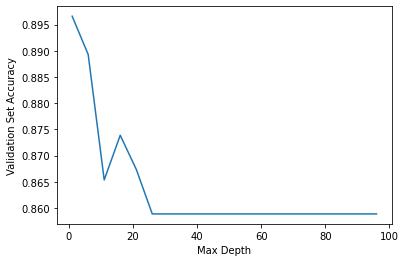

In [41]:
depths = np.arange(1, 101, 5)
val_acc_list = []

for d in depths:
    boost = GradientBoostingClassifier(n_estimators=6, learning_rate=1.0,
                                        max_depth=d, random_state=0).fit(X_train, y_train)
    
    val_acc_list.append(boost.score(X_val, y_val))
    print(f'Completed depth {d}')

plt.plot(depths, val_acc_list)
plt.xlabel('Max Depth')
plt.ylabel('Validation Set Accuracy')

In [42]:
val_acc_list[0]

0.8965936739659367

In [ ]:
(10*10*10)*5

In [44]:
num_trees = np.arange(1, 51, 10)
learning_rates = np.linspace(0.1,1.1,5)
depths = np.arange(1, 5, 1)
val_acc_list = []
hyperparameter_combo = []

for n in num_trees:
    for lr in learning_rates:
        for d in depths:
            boost = GradientBoostingClassifier(n_estimators=n, learning_rate=lr,
                                        max_depth=d, random_state=0).fit(X_train, y_train)
    
            val_acc_list.append(boost.score(X_val, y_val))
            print(f'Completed tree {n} and learning rate of {lr} and depth of {d}')
            hyperparameter_combo.append((n,lr,d))

Completed tree 1 and learning rate of 0.1 and depth of 1
Completed tree 1 and learning rate of 0.1 and depth of 2
Completed tree 1 and learning rate of 0.1 and depth of 3
Completed tree 1 and learning rate of 0.1 and depth of 4
Completed tree 1 and learning rate of 0.35 and depth of 1
Completed tree 1 and learning rate of 0.35 and depth of 2
Completed tree 1 and learning rate of 0.35 and depth of 3
Completed tree 1 and learning rate of 0.35 and depth of 4
Completed tree 1 and learning rate of 0.6 and depth of 1
Completed tree 1 and learning rate of 0.6 and depth of 2
Completed tree 1 and learning rate of 0.6 and depth of 3
Completed tree 1 and learning rate of 0.6 and depth of 4
Completed tree 1 and learning rate of 0.85 and depth of 1
Completed tree 1 and learning rate of 0.85 and depth of 2
Completed tree 1 and learning rate of 0.85 and depth of 3
Completed tree 1 and learning rate of 0.85 and depth of 4
Completed tree 1 and learning rate of 1.1 and depth of 1
Completed tree 1 and le

Text(0.5, 0.5, 'Max Depth')

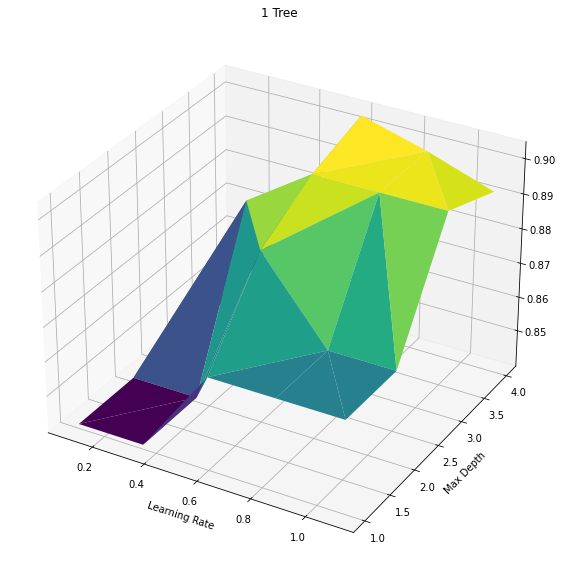

In [49]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][:20],
             list(zip(*hyperparameter_combo))[2][:20],
             val_acc_list[:20], cmap='viridis')
ax.set_title('1 Tree')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0.5, 'Max Depth')

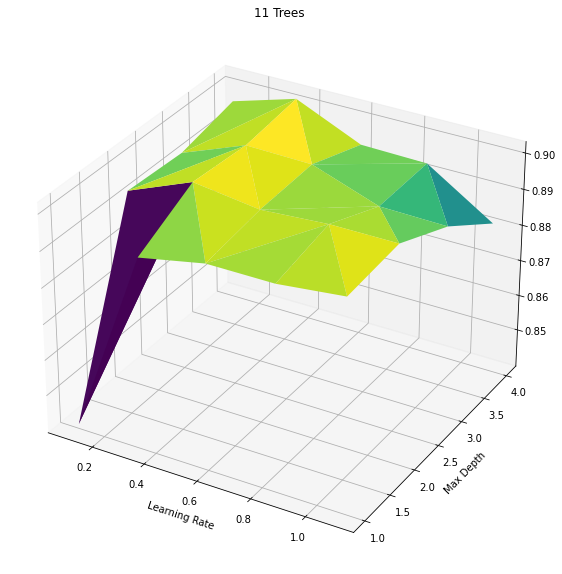

In [50]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][20:40],
             list(zip(*hyperparameter_combo))[2][20:40],
             val_acc_list[20:40], cmap='viridis')
ax.set_title('11 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0.5, 'Max Depth')

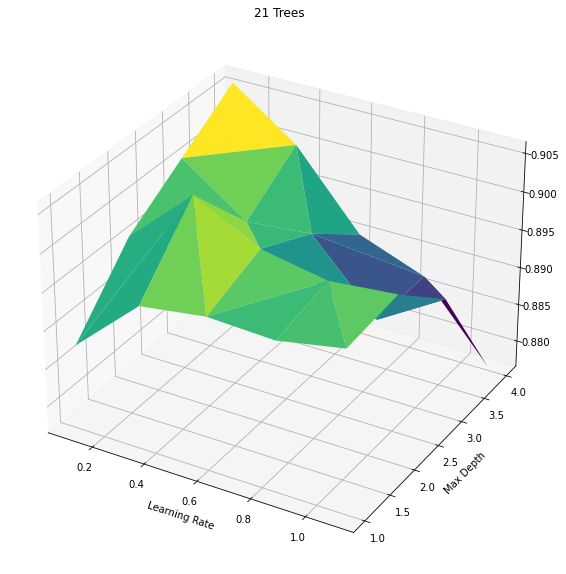

In [51]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][40:60],
             list(zip(*hyperparameter_combo))[2][40:60],
             val_acc_list[40:60], cmap='viridis')
ax.set_title('21 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0.5, 'Max Depth')

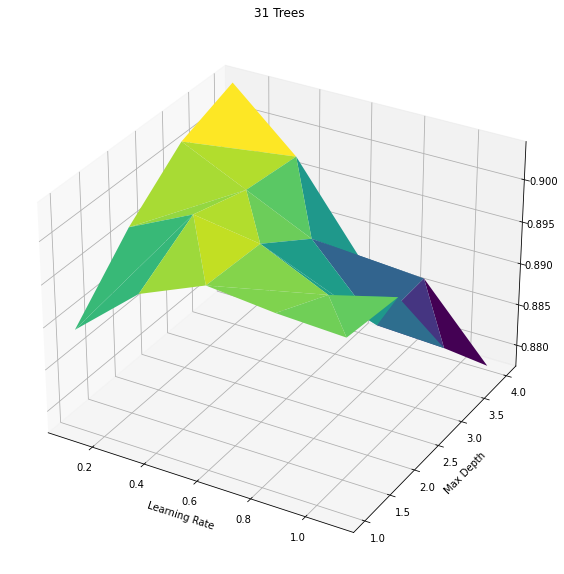

In [52]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][60:80],
             list(zip(*hyperparameter_combo))[2][60:80],
             val_acc_list[60:80], cmap='viridis')
ax.set_title('31 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

Text(0.5, 0.5, 'Max Depth')

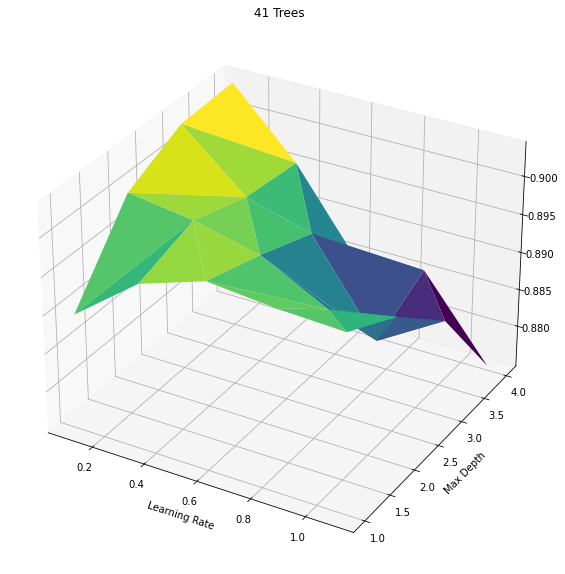

In [53]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.plot_trisurf(list(zip(*hyperparameter_combo))[1][80:100],
             list(zip(*hyperparameter_combo))[2][80:100],
             val_acc_list[80:100], cmap='viridis')
ax.set_title('41 Trees')
plt.xlabel('Learning Rate')
plt.ylabel('Max Depth')

#### Optimal Hyperparameters

In [54]:
print(np.max(val_acc_list), hyperparameter_combo[np.argmax(val_acc_list)])

0.9059205190592052 (21, 0.1, 4)


In [55]:
boost = GradientBoostingClassifier(n_estimators=list(zip(*hyperparameter_combo))[0][np.argmax(val_acc_list)],
                                   learning_rate=list(zip(*hyperparameter_combo))[1][np.argmax(val_acc_list)],
                                   max_depth=list(zip(*hyperparameter_combo))[2][np.argmax(val_acc_list)],
                                   random_state=0).fit(X_train, y_train)
boost.score(X_test,y_test)

0.9051094890510949

#### Warm start

In [56]:
boost = GradientBoostingClassifier(n_estimators=5,
                                   learning_rate=0.1,
                                   max_depth=1,
                                   random_state=0, warm_start = True).fit(X_train, y_train)
boost.score(X_val, y_val)

0.8406326034063261

In [57]:
boost.set_params(n_estimators=100)
boost.fit(X_train,y_train)
boost.score(X_val, y_val)

0.8921330089213301

## XGBoost
There are too many hyperparameters to list here so let's go to the documentation: https://xgboost.readthedocs.io/en/stable/python/python_api.html#module-xgboost.sklearn

In [61]:
t0=time.time()
xgb = XGBClassifier(use_label_encoder=False, 
                    eval_metric='error', 
                    n_estimators= 100,
                    max_depth= 1,
                    gamma=0.4,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    objective= 'binary:logistic',
                    nthread= -1)
xgb.fit(X_train, y_train)
t1=time.time()
xgb.score(X_val,y_val)

/Users/sharad/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


0.8933495539334956

In [62]:
t1-t0

0.32171106338500977

In [63]:
print(f'Hours to complete at 0.5s per iteration: {(10*10*10*10)*0.5/60/60}')

Hours to complete at 0.5s per iteration: 1.3888888888888888


In [ ]:
num_trees = np.arange(100, 1001, 100)
subsample_size = np.linspace(0.1,1,10)
colsample_size = np.linspace(0.1,1,10)
gammas_= = np.linspace(0.1,1,10)
val_acc_list = []
hyperparameter_combo = []

i=0
for n in num_trees:
    for g in gamma:
        for d in depths:
            for col in colsample_size:
                for sub in subsample_size:
                    xgb = XGBClassifier(use_label_encoder=False, 
                            eval_metric='error', 
                            n_estimators= n,
                            max_depth= 1,
                            gamma=g,
                            subsample=sub,
                            colsample_bytree=col,
                            objective= 'binary:logistic',
                            nthread= -1)
                    print(i)
                    i+=1
    
            val_acc_list.append(xgb.score(X_val, y_val))
            hyperparameter_combo.append((n,lr,d))